Evaluating: (40, 48, 52)
R²: 0.38245
Evaluating: (12, 59, 33)
R²: 0.49603
Evaluating: (34, 41, 83)
R²: 0.45511
Evaluating: (97, 80, 41)
R²: 0.38338
Evaluating: (20, 57, 79)
R²: 0.39842
Evaluating: (34, 67, 33)
R²: 0.32346
Evaluating: (8, 95, 20)
R²: 0.55159
Evaluating: (31, 60, 58)
R²: 0.31650
Evaluating: (13, 21, 74)
R²: 0.23083
Evaluating: (17, 40, 6)
R²: -0.01684
Evaluating: (54, 28, 53)
R²: 0.48857
Evaluating: (40, 40, 45)
R²: 0.27808
Evaluating: (60, 62, 57)
R²: 0.48063
Evaluating: (85, 32, 13)
R²: 0.35702
Evaluating: (68, 26, 83)
R²: 0.53947
Evaluating: (43, 69, 91)
R²: 0.22460
Evaluating: (70, 94, 97)
R²: 0.27051
Evaluating: (60, 99, 30)
R²: 0.42944
Evaluating: (58, 6, 76)
R²: 0.48055
Evaluating: (89, 7, 36)
R²: 0.43992
Evaluating: (5, 5, 5)
R²: 0.51554
Evaluating: (14, 83, 33)
R²: 0.39953
Evaluating: (26, 84, 44)
R²: 0.17952
Evaluating: (5, 51, 65)
R²: 0.60846
Evaluating: (5, 100, 5)
R²: 0.66848
Evaluating: (7, 85, 11)
R²: 0.59352
Evaluating: (24, 98, 29)
R²: 0.31704
Evaluating

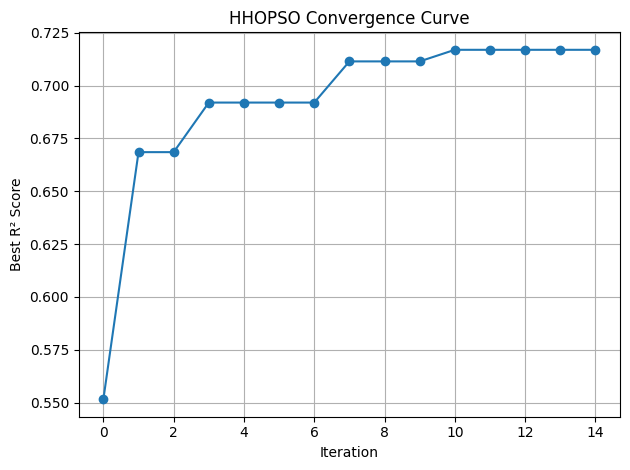

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning
from hhopso import HHOPSO  # Ensure your HHOPSO module is accessible

# === Suppress convergence warnings ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# === Load dataset ===
csv_file = 'processed_heat_stress_data_UNSCALED.csv'
input_cols = list(range(2, 5)) + list(range(6, 12))
target_col = 12
data = pd.read_csv(csv_file).dropna()
X = data.iloc[:, input_cols].values
y = data.iloc[:, target_col].values

# === Train-test split (70% train, 30% test) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# === Normalize using only training data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Objective function ===
def nn_objective(x):
    l1 = int(np.clip(np.round(x[0]), 5, 100))
    l2 = int(np.clip(np.round(x[1]), 5, 100))
    l3 = int(np.clip(np.round(x[2]), 5, 100))

    try:
        print(f"Evaluating: ({l1}, {l2}, {l3})")
        model = MLPRegressor(
            hidden_layer_sizes=(l1, l2, l3),
            activation='tanh',
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        print(f"R²: {r2:.5f}")
    except Exception as e:
        r2 = -np.inf
        print(f"Failed: {e}")

    return -r2  # HHOPSO minimizes

# === HHOPSO Settings ===
dim = 3
bounds = np.array([
    [5, 100],  # Layer 1 neurons
    [5, 100],  # Layer 2 neurons
    [5, 100],  # Layer 3 neurons
])
steps = 15
pop_size = 20
w = 0.4
c1 = 2.05
c2 = 2.05
seed = 75
vis = False

# === Start timing ===
start_time = time.time()

# === Run HHOPSO ===
bestsol, bestfit, hist = HHOPSO(
    func=nn_objective,
    dim=dim,
    bounds=bounds,
    steps=steps,
    size=pop_size,
    w=w,
    c1=c1,
    c2=c2,
    seed=seed,
    vis=vis
)

# === Convert convergence history from -R² to R² ===
r2_history = [-f for f in hist]

# === Save convergence curve to CSV ===
df_hist = pd.DataFrame({
    'Iteration': range(1, len(r2_history) + 1),
    'Best_R2': r2_history
})
df_hist.to_csv('convergence_run8.csv', index=False)
print("Convergence history saved to 'convergence_run8.csv'")

# === Retrain best model and compute metrics ===
best_l1 = int(np.round(bestsol[0]))
best_l2 = int(np.round(bestsol[1]))
best_l3 = int(np.round(bestsol[2]))

final_model = MLPRegressor(
    hidden_layer_sizes=(best_l1, best_l2, best_l3),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
final_model.fit(X_train_scaled, y_train)
final_preds = final_model.predict(X_test_scaled)

final_r2 = r2_score(y_test, final_preds)
final_mse = mean_squared_error(y_test, final_preds)
final_mae = mean_absolute_error(y_test, final_preds)

# === End timing ===
end_time = time.time()
elapsed_time = end_time - start_time

# === Output ===
print("\nBest hidden layer sizes found:")
print(f"  Layer 1 size: {best_l1}")
print(f"  Layer 2 size: {best_l2}")
print(f"  Layer 3 size: {best_l3}")
print(f"\nPerformance on Test Set:")
print(f"  R² Score: {final_r2:.5f}")
print(f"  Mean Squared Error (MSE): {final_mse:.5f}")
print(f"  Mean Absolute Error (MAE): {final_mae:.5f}")
print(f"\nTotal Runtime: {elapsed_time:.2f} seconds")

# === Plot Convergence Curve ===
plt.plot(r2_history, marker='o', linestyle='-')
plt.title("HHOPSO Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Best R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluating: (40, 48, 52)
R²: 0.38245
Evaluating: (12, 59, 33)
R²: 0.49603
Evaluating: (34, 41, 83)
R²: 0.45511
Evaluating: (97, 80, 41)
R²: 0.38338
Evaluating: (20, 57, 79)
R²: 0.39842
Evaluating: (34, 67, 33)
R²: 0.32346
Evaluating: (8, 95, 20)
R²: 0.55159
Evaluating: (31, 60, 58)
R²: 0.31650
Evaluating: (13, 21, 74)
R²: 0.23083
Evaluating: (17, 40, 6)
R²: -0.01684
Evaluating: (54, 28, 53)
R²: 0.48857
Evaluating: (40, 40, 45)
R²: 0.27808
Evaluating: (60, 62, 57)
R²: 0.48063
Evaluating: (85, 32, 13)
R²: 0.35702
Evaluating: (68, 26, 83)
R²: 0.53947
Evaluating: (43, 69, 91)
R²: 0.22460
Evaluating: (70, 94, 97)
R²: 0.27051
Evaluating: (60, 99, 30)
R²: 0.42944
Evaluating: (58, 6, 76)
R²: 0.48055
Evaluating: (89, 7, 36)
R²: 0.43992
Evaluating: (5, 5, 5)
R²: 0.51554
Evaluating: (14, 83, 33)
R²: 0.39953
Evaluating: (26, 84, 44)
R²: 0.17952
Evaluating: (5, 51, 65)
R²: 0.60846
Evaluating: (5, 100, 5)
R²: 0.66848
Evaluating: (7, 85, 11)
R²: 0.59352
Evaluating: (24, 98, 29)
R²: 0.31704
Evaluating

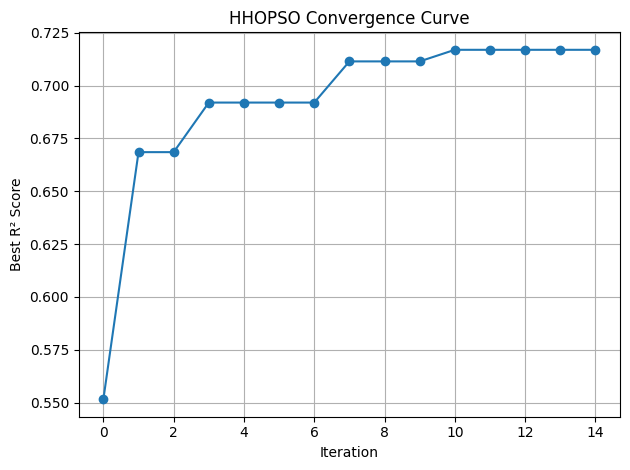

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning
from hhopso import HHOPSO  # Ensure your HHOPSO module is accessible

# === Suppress convergence warnings ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# === Load dataset ===
csv_file = 'processed_heat_stress_data_UNSCALED.csv'
input_cols = list(range(2, 5)) + list(range(6, 12))
target_col = 12
data = pd.read_csv(csv_file).dropna()
X = data.iloc[:, input_cols].values
y = data.iloc[:, target_col].values

# === Train-test split (70% train, 30% test) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# === Normalize using only training data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Objective function ===
def nn_objective(x):
    l1 = int(np.clip(np.round(x[0]), 5, 100))
    l2 = int(np.clip(np.round(x[1]), 5, 100))
    l3 = int(np.clip(np.round(x[2]), 5, 100))

    try:
        print(f"Evaluating: ({l1}, {l2}, {l3})")
        model = MLPRegressor(
            hidden_layer_sizes=(l1, l2, l3),
            activation='tanh',
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        print(f"R²: {r2:.5f}")
    except Exception as e:
        r2 = -np.inf
        print(f"Failed: {e}")

    return -r2  # HHOPSO minimizes

# === HHOPSO Settings ===
dim = 3
bounds = np.array([
    [5, 100],  # Layer 1 neurons
    [5, 100],  # Layer 2 neurons
    [5, 100],  # Layer 3 neurons
])
steps = 15
pop_size = 20
w = 0.4
c1 = 2.05
c2 = 2.05
seed = 75
vis = False

# === Start timing ===
start_time = time.time()

# === Run HHOPSO ===
bestsol, bestfit, hist = HHOPSO(
    func=nn_objective,
    dim=dim,
    bounds=bounds,
    steps=steps,
    size=pop_size,
    w=w,
    c1=c1,
    c2=c2,
    seed=seed,
    vis=vis
)

# === Convert convergence history from -R² to R² ===
r2_history = [-f for f in hist]

# === Save convergence curve to CSV ===
df_hist = pd.DataFrame({
    'Iteration': range(1, len(r2_history) + 1),
    'Best_R2': r2_history
})
df_hist.to_csv('convergence_run8.csv', index=False)
print("Convergence history saved to 'convergence_run8.csv'")

# === Retrain best model and compute metrics ===
best_l1 = int(np.round(bestsol[0]))
best_l2 = int(np.round(bestsol[1]))
best_l3 = int(np.round(bestsol[2]))

final_model = MLPRegressor(
    hidden_layer_sizes=(best_l1, best_l2, best_l3),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
final_model.fit(X_train_scaled, y_train)
final_preds = final_model.predict(X_test_scaled)

final_r2 = r2_score(y_test, final_preds)
final_mse = mean_squared_error(y_test, final_preds)
final_mae = mean_absolute_error(y_test, final_preds)

# === End timing ===
end_time = time.time()
elapsed_time = end_time - start_time

# === Output ===
print("\nBest hidden layer sizes found:")
print(f"  Layer 1 size: {best_l1}")
print(f"  Layer 2 size: {best_l2}")
print(f"  Layer 3 size: {best_l3}")
print(f"\nPerformance on Test Set:")
print(f"  R² Score: {final_r2:.5f}")
print(f"  Mean Squared Error (MSE): {final_mse:.5f}")
print(f"  Mean Absolute Error (MAE): {final_mae:.5f}")
print(f"\nTotal Runtime: {elapsed_time:.2f} seconds")

# === Plot Convergence Curve ===
plt.plot(r2_history, marker='o', linestyle='-')
plt.title("HHOPSO Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Best R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()


2025/08/03 10:12:43 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: OriginalPSO(epoch=15, pop_size=20, c1=2.05, c2=2.05, w=0.4)
2025/08/03 10:15:21 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: -0.5591236030911696, Global best: -0.5591236030911696, Runtime: 53.31356 seconds
2025/08/03 10:16:23 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: -0.5591236030911696, Global best: -0.5591236030911696, Runtime: 61.78817 seconds
2025/08/03 10:18:17 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: -0.6456260897234345, Global best: -0.6456260897234345, Runtime: 113.80819 seconds
2025/08/03 10:20:14 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: -0.6456260897234345, Global best: -0.6456260897234345, Runtime: 117.13114 seconds
2025/08/03 10:22:40 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: -0.6456260897234345, Gl


[PSO] Best hidden layer sizes found:
  Layer 1 size: 39
  Layer 2 size: 12
  Layer 3 size: 21

[PSO] Performance on Test Set:
  R² Score: 0.66368
  Mean Squared Error (MSE): 88.29704
  Mean Absolute Error (MAE): 5.71216

[PSO] Total Runtime: 1395.48 seconds
Convergence history saved to 'pso_convergence_run9.csv'


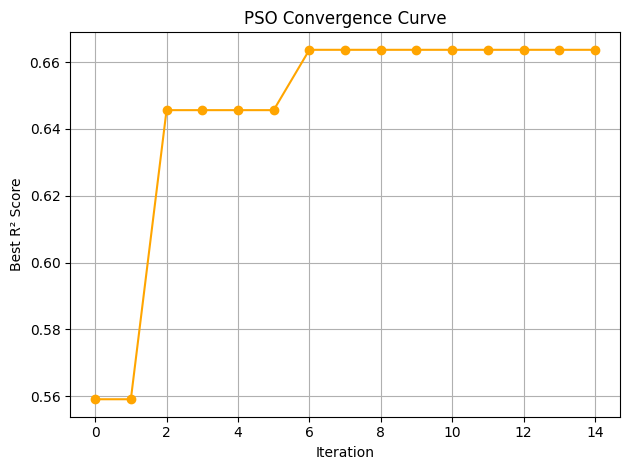

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning
from mealpy.swarm_based import PSO
from mealpy.utils.space import IntegerVar
from mealpy.utils.problem import Problem

# === Suppress convergence warnings ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# === Load dataset ===
csv_file = 'processed_heat_stress_data_UNSCALED.csv'
input_cols = list(range(2, 5)) + list(range(6, 12))
target_col = 12
data = pd.read_csv(csv_file).dropna()
X = data.iloc[:, input_cols].values
y = data.iloc[:, target_col].values

# === Train-test split (70% train, 30% test) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# === Normalize using only training data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Objective function ===
def nn_objective(solution):
    l1 = int(np.clip(np.round(solution[0]), 5, 100))
    l2 = int(np.clip(np.round(solution[1]), 5, 100))
    l3 = int(np.clip(np.round(solution[2]), 5, 100))

    try:
        model = MLPRegressor(
            hidden_layer_sizes=(l1, l2, l3),
            activation='tanh',
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
    except Exception:
        r2 = -np.inf

    return [-r2]  # MEALPY minimizes

# === PSO Settings ===
problem = Problem(
    obj_func=nn_objective,
    bounds=[
        IntegerVar(5, 100),
        IntegerVar(5, 100),
        IntegerVar(5, 100)
    ],
    minmax="min",
    log_to_console=True
)

model = PSO.OriginalPSO(
    epoch=15,
    pop_size=20,
    seed=8
)

# === Start timing ===
start_time = time.time()

# === Run PSO optimization ===
agent = model.solve(problem=problem)
best_solution = agent.solution
best_fitness = agent.target
pso_history = model.history

# === End timing ===
end_time = time.time()
elapsed_time = end_time - start_time

# === Extract best hyperparameters ===
best_l1 = int(np.round(best_solution[0]))
best_l2 = int(np.round(best_solution[1]))
best_l3 = int(np.round(best_solution[2]))

# === Retrain final model ===
final_model = MLPRegressor(
    hidden_layer_sizes=(best_l1, best_l2, best_l3),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
final_model.fit(X_train_scaled, y_train)
final_preds = final_model.predict(X_test_scaled)

final_r2 = r2_score(y_test, final_preds)
final_mse = mean_squared_error(y_test, final_preds)
final_mae = mean_absolute_error(y_test, final_preds)

# === Output ===
print("\n[PSO] Best hidden layer sizes found:")
print(f"  Layer 1 size: {best_l1}")
print(f"  Layer 2 size: {best_l2}")
print(f"  Layer 3 size: {best_l3}")
print(f"\n[PSO] Performance on Test Set:")
print(f"  R² Score: {final_r2:.5f}")
print(f"  Mean Squared Error (MSE): {final_mse:.5f}")
print(f"  Mean Absolute Error (MAE): {final_mae:.5f}")
print(f"\n[PSO] Total Runtime: {elapsed_time:.2f} seconds")

# === Convergence Curve from Mealpy ===
loss_train = pso_history.list_global_best_fit  # This is [-R²]
r2_history = [-loss for loss in loss_train]    # Flip sign to get R²

# === Save convergence curve to CSV ===
df_pso_hist = pd.DataFrame({
    'Iteration': range(1, len(r2_history) + 1),
    'Best_R2': r2_history
})
df_pso_hist.to_csv('pso_convergence_run10.csv', index=False)
print("Convergence history saved to 'pso_convergence_run10.csv'")

# === Plot convergence curve ===
plt.plot(r2_history, marker='o', linestyle='-', color='orange')
plt.title("PSO Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Best R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()
